In [ ]:
import pandas as pd
import networkx as nx
import os
import numpy as np
import warnings
import numpy as np
import matplotlib.pyplot as plt

from nxviz import CircosPlot
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Tables to Networks, Networks to Tables

Networks can be represented in a tabular form in two ways: As an adjacency list with edge attributes stored as columnar values, and as a node list with node attributes stored as columnar values.

Storing the network data as a single massive adjacency table, with node attributes repeated on each row, can get unwieldy, especially if the graph is large, or grows to be so. One way to get around this is to store two files: one with node data and node attributes, and one with edge data and edge attributes. 

The Divvy bike sharing dataset is one such example of a network data set that has been stored as such.

# Loading Node Lists and Adjacency Lists

Let's use the Divvy bike sharing data set as a starting point. The Divvy data set is comprised of the following data:

- Stations and metadata (like a node list with attributes saved)
- Trips and metadata (like an edge list with attributes saved)

The `README.txt` file in the Divvy directory should help orient you around the data.

In [ ]:
import zipfile
# This block of code checks to make sure that a particular directory is present.
if "divvy_2013" not in os.listdir('datasets/'):
    print('Unzipping the divvy_2013.zip file in the datasets folder.')
    with zipfile.ZipFile("datasets/divvy_2013.zip","r") as zip_ref:
        zip_ref.extractall('datasets')

In [ ]:
stations = pd.read_csv('datasets/divvy_2013/Divvy_Stations_2013.csv', parse_dates=['online date'], encoding='utf-8')
stations.head(10)

In [ ]:
trips = pd.read_csv('datasets/divvy_2013/Divvy_Trips_2013.csv', 
                    parse_dates=['starttime', 'stoptime'])
trips.head(10)

At this point, we have our `stations` and `trips` data loaded into memory. 

How we construct the graph depends on the kind of questions we want to answer, which makes the definition of the "unit of consideration" (or the entities for which we are trying to model their relationships) is extremely important. 

Let's try to answer the question: "What are the most popular trip paths?" In this case, the bike station is a reasonable "unit of consideration", so we will use the bike stations as the nodes. 

To start, let's initialize an directed graph `G`.

In [ ]:
G = nx.DiGraph()

Then, let's iterate over the `stations` DataFrame, and add in the node attributes.

In [ ]:
for d in stations.to_dict('records'): # each row is a dictionary
    node_id = d.pop('id')
    G.add_node(node_id, attr_dict=d) 

In order to answer the question of "which stations are important", we need to specify things a bit more. Perhaps a measure such as **betweenness centrality** or **degree centrality** may be appropriate here.

The naive way would be to iterate over all the rows. Go ahead and try it at your own risk - it may take a long time :-). Alternatively, I would suggest doing a `pandas` `groupby`.

In [ ]:
# # Run the following code at your own risk :)
# for r, d in trips.iterrows():
#     start = d['from_station_id']
#     end = d['to_station_id']
#     if (start, end) not in G.edges():
#         G.add_edge(start, end, count=1)
#     else:
#         G.edge[start][end]['count'] += 1

In [ ]:
counts = trips.groupby(['from_station_id', 'to_station_id'])['trip_id'].count().reset_index()
for d in counts.to_dict('records'):
    G.add_edge(d['from_station_id'], d['to_station_id'], count=d['trip_id'])

## Exercise

Flex your memory muscles: can you make a scatter plot of the distribution of the number edges that have a certain number of trips? (3 min.)

The x-value is the number of trips taken between two stations, and the y-vale is be the number of edges that have that number of trips.

In [ ]:
from collections import Counter
# Count the number of edges that have x trips recorded on them.
trip_count_distr = ______________________________

# Then plot the distribution of these
plt.scatter(_______________, _______________, alpha=0.1)
plt.yscale('log')
plt.xlabel('num. of trips')
plt.ylabel('num. of edges')

## Exercise

Create a new graph, and filter out the edges such that only those with more than 100 trips taken (i.e. `count >= 100`) are left. (3 min.)

In [ ]:
# Filter the edges to just those with more than 100 trips.
G_filtered = G.copy()
for u, v, d in G.edges(data=True):
    # Fill in your code here.
        
len(G_filtered.edges())

Let's now try drawing the graph.

## Exercise

Use `nx.draw_kamada_kawai(my_graph)` to draw the filtered graph to screen. This uses a force-directed layout. (1 min.)

In [ ]:
# Fill in your code here.


Finally, let's visualize this as a GIS person might see it, taking advantage of the latitude and longitude data.

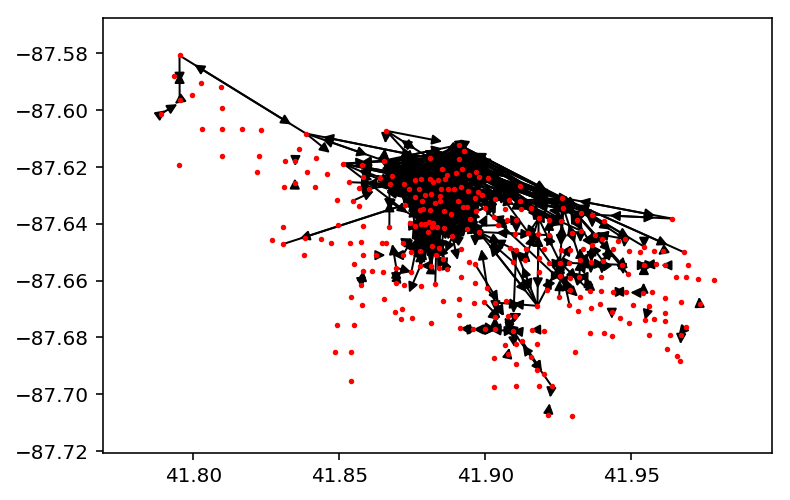

In [38]:
locs = {n: np.array([d['latitude'], d['longitude']]) for n, d in G_filtered.nodes(data=True)}
# for n, d in G_filtered.nodes(data=True):
#     print(n, d.keys())
nx.draw_networkx_nodes(G_filtered, pos=locs, node_size=3)
nx.draw_networkx_edges(G_filtered, pos=locs)
plt.show()

## Exercise

Try visualizing the graph using a CircosPlot. Order the nodes by their connectivity in the **original** graph, but plot only the **filtered** graph edges. (3 min.)

You may have to first annotate the connectivity of each node, as given by the number of neighbors that any node is connected to.

In [ ]:
for n in G_filtered.nodes():
    ____________

c = CircosPlot(__________)
__________
plt.savefig('images/divvy.png', dpi=300)

In this visual, nodes are sorted from highest connectivity to lowest connectivity in the **unfiltered** graph.

Edges represent only trips that were taken >100 times between those two nodes.

Some things should be quite evident here. There are lots of trips between the highly connected nodes and other nodes, but there are local "high traffic" connections between stations of low connectivity as well (nodes in the top-right quadrant).

# Saving NetworkX Graph Files

NetworkX's API offers many formats for storing graphs to disk. If you intend to work exclusively with NetworkX, then pickling the file to disk is probably the easiest way.

To write to disk: 

    nx.write_gpickle(G, handle)

To load from disk:
    
    G = nx.read_gpickle(handle)

In [ ]:
nx.write_gpickle(G, 'datasets/divvy_2013/divvy_graph.pkl')

In [ ]:
G = nx.read_gpickle('datasets/divvy_2013/divvy_graph.pkl')